In [1]:
from google.colab import drive,output

drive.mount('/content/drive')
!ln -s "/content/drive/MyDrive/proyecto/Codigos"

Mounted at /content/drive


In [3]:
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))
# os.chdir("/content/drive/MyDrive/Codigos")
os.chdir("./Codigos")
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content
Current working directory: /content/drive/MyDrive/proyecto/Codigos


In [4]:
# descarga, descomprimir archivos y lectura pkl
!pip install google.colab
from google.colab import drive
!pip install zipfile_deflate64
import zipfile_deflate64 as zipfile
import pickle

# librerias genericas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# librerias de arquitectura
import time
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
with open('128.npy', 'rb') as f:
    vector_train128 = np.load(f)
    labels_train = np.load(f)
    vector_val128= np.load(f)
    labels_val= np.load(f)
    vector_test128= np.load(f)
    labels_test= np.load(f)


with open('64.npy', 'rb') as f:
    vector_train64 = np.load(f)
    labels_train = np.load(f)
    vector_val64= np.load(f)
    labels_val =np.load(f)
    vector_test64= np.load(f)
    labels_test= np.load(f)
    
    

In [6]:
datatrain128 = TensorDataset(torch.Tensor(vector_train128),torch.Tensor(labels_train))
dataval128 = TensorDataset(torch.Tensor(vector_val128),torch.Tensor(labels_val))
datatest128 = TensorDataset(torch.Tensor(vector_test128),torch.Tensor(labels_test))


In [7]:
class MLPModel128(nn.Module):
    def __init__(self, dropout_p):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 100),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
        )

    def forward(self, x):
        # result = torch.argmax(, axis=1)
        # result = result.reshape(result.shape[0],1)
        return self.net(x)

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [ ]:
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
model =MLPModel128(dropout_p=0.5).to(device)
criterion =nn.CrossEntropyLoss()
learning_rate=0.0001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_total_steps= len(datatrain128)
num_epochs=100
batch_size=64
use_gpu=True

train_loader = torch.utils.data.DataLoader(datatrain128, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
val_loader = torch.utils.data.DataLoader(dataval128, batch_size=len(dataval128), shuffle=False, pin_memory=use_gpu)
iteration = 0
n_batches = len(train_loader)

n_evaluations_per_epoch=5
curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

for epoch in range(num_epochs):
    print(f"\rEpoch {epoch + 1}/{num_epochs}")
    cumulative_train_loss = 0
    cumulative_train_corrects = 0
    train_loss_count = 0
    train_acc_count = 0
    for i,(x_batch, y_batch) in enumerate(train_loader):
        y_batch = y_batch.type(torch.LongTensor)
        if use_gpu:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        # Predicción
        y_predicted = model(x_batch)

        loss = criterion(y_predicted, y_batch)

        class_prediction = torch.argmax(y_predicted, axis=1).long()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_train_loss += loss.item()
        train_loss_count += 1
        train_acc_count += y_batch.shape[0]
        cumulative_train_corrects += (y_batch == class_prediction).sum().item()
        if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
            train_loss = cumulative_train_loss / train_loss_count
            train_acc = cumulative_train_corrects / train_acc_count

            print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1
    with torch.no_grad():
        cumulative_loss = 0
        cumulative_predictions = 0
        data_count = 0

        for x_val, y_val in val_loader:
            y_val = y_val.type(torch.LongTensor)
            if use_gpu:
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            y_predicted = model(x_val)
            
            loss = criterion(y_predicted, y_val)

            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_predictions += (y_val == class_prediction).sum().item()
            cumulative_loss += loss.item()
            data_count += y_val.shape[0]

        val_acc = cumulative_predictions / data_count
        val_loss = cumulative_loss / len(val_loader)
    print(f"Val loss: {val_loss}, Val acc: {val_acc}")
    curves["train_acc"].append(train_acc)
    curves["val_acc"].append(val_acc)
    curves["train_loss"].append(train_loss)
    curves["val_loss"].append(val_loss)


    
show_curves(curves)


Epoch 1/100
Iteration 0 - Batch 227/1137 - Train loss: 1.620304783185323, Train acc: 0.26973684210526316
Iteration 1 - Batch 454/1137 - Train loss: 1.5122697578681694, Train acc: 0.3432348901098901
Iteration 2 - Batch 681/1137 - Train loss: 1.385776840521793, Train acc: 0.43101631231671556
Iteration 3 - Batch 908/1137 - Train loss: 1.285956607793424, Train acc: 0.48827695269526955
Iteration 4 - Batch 1135/1137 - Train loss: 1.2125505875323859, Train acc: 0.5257895026408451
Val loss: 0.9072030186653137, Val acc: 0.668
Epoch 2/100
Iteration 5 - Batch 227/1137 - Train loss: 0.8653362500563002, Train acc: 0.6927768640350878
Iteration 6 - Batch 454/1137 - Train loss: 0.8355986031857165, Train acc: 0.7041552197802198
Iteration 7 - Batch 681/1137 - Train loss: 0.8198236643918448, Train acc: 0.7082569648093842
Iteration 8 - Batch 908/1137 - Train loss: 0.8050505979882084, Train acc: 0.7131463146314632
Iteration 9 - Batch 1135/1137 - Train loss: 0.7949385334488371, Train acc: 0.7161366637323944

In [ ]:
datatrain64 = TensorDataset(torch.Tensor(vector_train64),torch.Tensor(labels_train))
dataval64 = TensorDataset(torch.Tensor(vector_val64),torch.Tensor(labels_val))
datatest64 = TensorDataset(torch.Tensor(vector_test64),torch.Tensor(labels_test))

In [ ]:
class MLPModel64(nn.Module):
    def __init__(self, dropout_p):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 50),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(50, 35),
            nn.ReLU(),
            nn.Linear(35, 20),
            nn.ReLU(),
            nn.Linear(20, 15),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(15, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
        )

    def forward(self, x):
        # result = torch.argmax(, axis=1)
        # result = result.reshape(result.shape[0],1)
        return self.net(x)

Epoch 1/100
Iteration 0 - Batch 227/1137 - Train loss: 1.6186585562270985, Train acc: 0.20079495614035087
Iteration 1 - Batch 454/1137 - Train loss: 1.5788027540668026, Train acc: 0.22156593406593406
Iteration 2 - Batch 681/1137 - Train loss: 1.504291082582166, Train acc: 0.26672470674486803
Iteration 3 - Batch 908/1137 - Train loss: 1.4360969094159972, Train acc: 0.29646245874587457
Iteration 4 - Batch 1135/1137 - Train loss: 1.3887190053790388, Train acc: 0.3171352332746479
Val loss: 1.1654162406921387, Val acc: 0.424
Epoch 2/100
Iteration 5 - Batch 227/1137 - Train loss: 1.1769539962212245, Train acc: 0.4058388157894737
Iteration 6 - Batch 454/1137 - Train loss: 1.1660221845239074, Train acc: 0.4107142857142857
Iteration 7 - Batch 681/1137 - Train loss: 1.1599970873325103, Train acc: 0.41209219208211145
Iteration 8 - Batch 908/1137 - Train loss: 1.1556559563076536, Train acc: 0.414380500550055
Iteration 9 - Batch 1135/1137 - Train loss: 1.1489179996432552, Train acc: 0.4167033450704

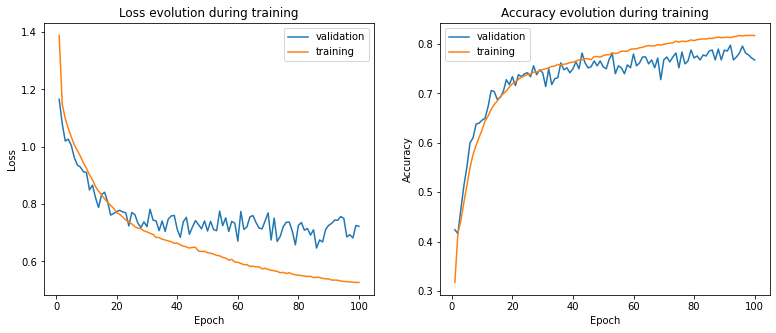

In [ ]:
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
model =MLPModel64(dropout_p=0.5).to(device)
criterion =nn.CrossEntropyLoss()
learning_rate=0.0001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
n_total_steps= len(datatrain64)
num_epochs=100
batch_size=64
use_gpu=True

train_loader = torch.utils.data.DataLoader(datatrain64, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)
val_loader = torch.utils.data.DataLoader(datatest64, batch_size=len(datatest64), shuffle=False, pin_memory=use_gpu)
iteration = 0
n_batches = len(train_loader)

n_evaluations_per_epoch=5
curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

for epoch in range(num_epochs):
    print(f"\rEpoch {epoch + 1}/{num_epochs}")
    cumulative_train_loss = 0
    cumulative_train_corrects = 0
    train_loss_count = 0
    train_acc_count = 0
    for i,(x_batch, y_batch) in enumerate(train_loader):
        y_batch = y_batch.type(torch.LongTensor)
        if use_gpu:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        # Predicción
        y_predicted = model(x_batch)

        loss = criterion(y_predicted, y_batch)

        class_prediction = torch.argmax(y_predicted, axis=1).long()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_train_loss += loss.item()
        train_loss_count += 1
        train_acc_count += y_batch.shape[0]
        cumulative_train_corrects += (y_batch == class_prediction).sum().item()
        if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
            train_loss = cumulative_train_loss / train_loss_count
            train_acc = cumulative_train_corrects / train_acc_count

            print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1
    with torch.no_grad():
        cumulative_loss = 0
        cumulative_predictions = 0
        data_count = 0

        for x_val, y_val in val_loader:
            y_val = y_val.type(torch.LongTensor)
            if use_gpu:
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            y_predicted = model(x_val)
            
            loss = criterion(y_predicted, y_val)

            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_predictions += (y_val == class_prediction).sum().item()
            cumulative_loss += loss.item()
            data_count += y_val.shape[0]

        val_acc = cumulative_predictions / data_count
        val_loss = cumulative_loss / len(val_loader)
    print(f"Val loss: {val_loss}, Val acc: {val_acc}")
    curves["train_acc"].append(train_acc)
    curves["val_acc"].append(val_acc)
    curves["train_loss"].append(train_loss)
    curves["val_loss"].append(val_loss)


    
show_curves(curves)